<img src="diamonds_img.jpeg" width="300" height="600" /> 

# Exploratory Data Analysis: Diamonds

# Introduction

The purpose of this notebook is to do some exploratory data analysis and machine learning on the "diamonds.csv" dataset. As the name of the file suggests, the dataset contains information about the attributes of various diamonds.

The dataset contains 10 variables:

* **carat** - This measures how much a diamond weighs. Continuous variable. 

* **cut** - This refers to the symmetry, proportions and polish of a diamond. Categoric variable with 5 labels - Fair, Good, Very Good, Premium, Ideal. Fair is the "worst" and Ideal is the "best".

* **color** - The color of the diamond is a categoric variable measured on scale from J to D, where J is the 'worst' and D is the 'best'.

* **clarity** - This measures how clear the diamond is. Categoric variable with 8 labels - I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best).

* **depth** (renamed **depth_perc** later) - This is a continuous variable measuring the total depth percentage. depth = $\frac{z}{mean(x, y)}$ = $\frac{2z}{x + y}$

* **table** - This is a continous variable measuring the width of the top of the diamond relative to its widest point.

* **price**- This is a continous variable measuring the price of the diamond in US Dollars. We will consider price to be the response variable.

* **x** - This is a continous variable measuring the length of the diamond in mm.

* **y** - This is a continous variable measuring the width of the diamond in mm.

* **z** - This is a continous variable measuring the depth of the diamond in mm. 

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score, accuracy_score

In [21]:
data = pd.read_csv("diamonds.csv")

A preview of the dataset can be seen below. 

In [22]:
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


As we can see, there is an "Unnamed: 0" column which is not really needed so we shall delete this column. Also, we rename the "depth" column to "depth_perc" (stands for depth percentage) so that no confusion arises with the "z" variable which measures the depth of the diamomd. The code below does exactly that.

In [23]:
data.rename(columns = {"depth":"depth_perc"}, inplace = True)
data.drop("Unnamed: 0", axis = 1, inplace = True)
data.head()

,carat,cut,color,clarity,depth_perc,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


It is important to check whether the dataset has any missing values as they can disrupt our future analysis. 

In [24]:
data.isnull().any()

carat         False
cut           False
color         False
clarity       False
depth_perc    False
table         False
price         False
x             False
y             False
z             False
dtype: bool

We can observe above that no column in the dataset contains any missing values. Hence, no reformatting needs to be done here.

# Descriptive Analysis

First, we shall perform some descriptive analysis and try and make some interesting initial observations.

As mentioned in the variable descriptions at the beginning of this notebook, we will consider "price" to be our response variable later so it will be useful to get a feel of how the "price" data is distributed.

Below, we have 2 plots. The left corresponds to an empirical cumulative distribution function of price. This gives us the proportion of the diamonds that have a price below a given price. The right plot is a histogram which gives us the frequency of diamonds that have a price within a given range.  

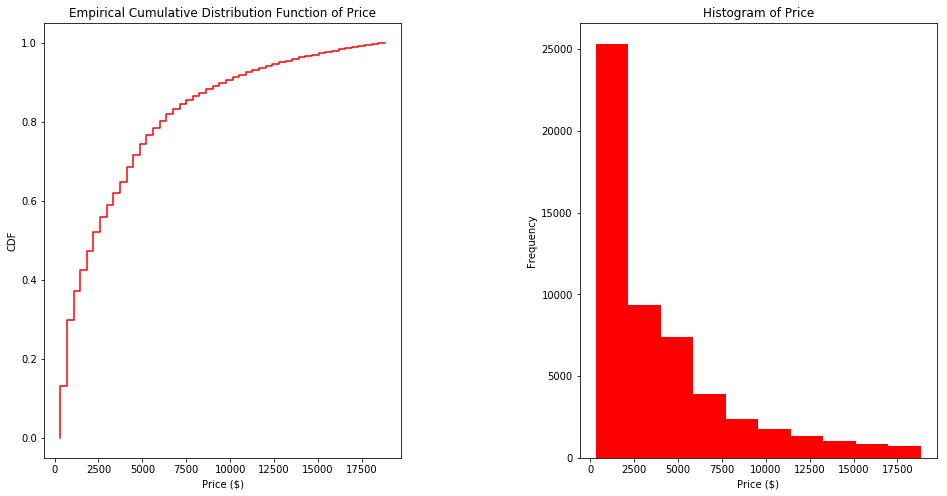

In [25]:
fig, ax = plt.subplots(figsize=(16,8),ncols=2)
ecdf = sm.distributions.ECDF(data["price"])
x = np.linspace(min(data["price"]), max(data["price"]))
y = ecdf(x)

ax[0].step(x,y, color = "red")
ax[0].set_xlabel('Price ($)')
ax[0].set_ylabel('CDF')
ax[0].set_title("Empirical Cumulative Distribution Function of Price")

ax[1].hist(data["price"], color = "red")
ax[1].set_xlabel("Price ($)")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Histogram of Price")

fig.subplots_adjust(wspace=0.5)
plt.show()

One striking observation from both plots above is that it seems the price data is approximately exponentially distributed; the CDF plot corresponds to the CDF of an exponential distribution and the histogram is of a very similar shape to the PDF plot of an exponentially distributed variable. 

We shall now compare the relationship between each of the categoric variables (cut, color, clarity) and price. This is illustrated in the 3 bar charts below. In each chart, the labels of each categoric variable are plotted in increasing order of the mean price. 
                       

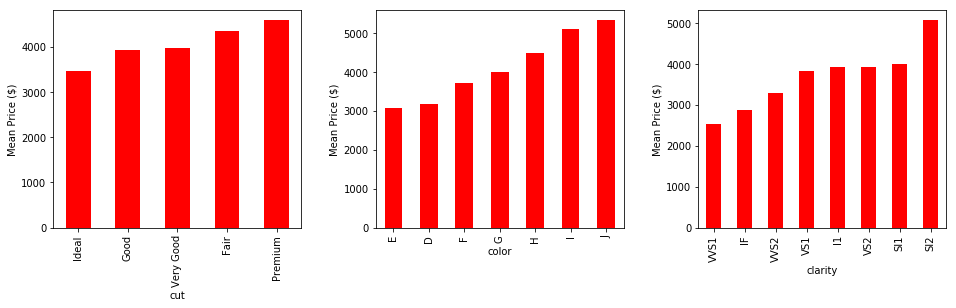

In [26]:
cut_data = data.groupby(["cut"])["price"].mean()
color_data = data.groupby(["color"])["price"].mean()
clarity_data = data.groupby(["clarity"])["price"].mean()

fig, axes = plt.subplots(ncols=3, figsize=(16, 4))

cut_data.sort_values().plot(kind="bar", color="red", ax=axes[0])
axes[0].set_ylabel("Mean Price ($)")

color_data.sort_values().plot(kind="bar", color="red", ax=axes[1])
axes[1].set_ylabel("Mean Price ($)")

clarity_data.sort_values().plot(kind="bar", color="red", ax=axes[2])
axes[2].set_ylabel("Mean Price ($)")

fig.subplots_adjust(wspace=0.3)

plt.show()

Let's first focus on the cut graph on the left. It would have been natural to expect the order of the bars (from left to right) to be "Fair", "Good", "Very Good", "Premium" and "Ideal". However, the order of the bars here is different, "Ideal" actually has the lowest mean price despite it being considered to be the "best" cut label!

For the color graph in the centre, we would expect the bars to be in alphabetical order from "J" to "D". However, in reality the bars are basically ordered in the opposite way!

For the clarity graph on the right, we would expect the order of the bars (from left to right) to be: "I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1" and "IF". However, once again the order is very different to what we would expect.

These findings are quite strange but it perhaps suggests that these categories on their own do not explain the price of a diamond very well; a combination of these variables may give a more accurate picture. Hopefully this will be supported in our later analysis. Also, another possible reason for these counter-intuitive results is that using the mean price to make comparisons between each label may not the best thing to do here as the price data is skewed. The skew within each label of the 3 categoric variables can be seen very clearly in the violin plots below - the upper tails are very long!


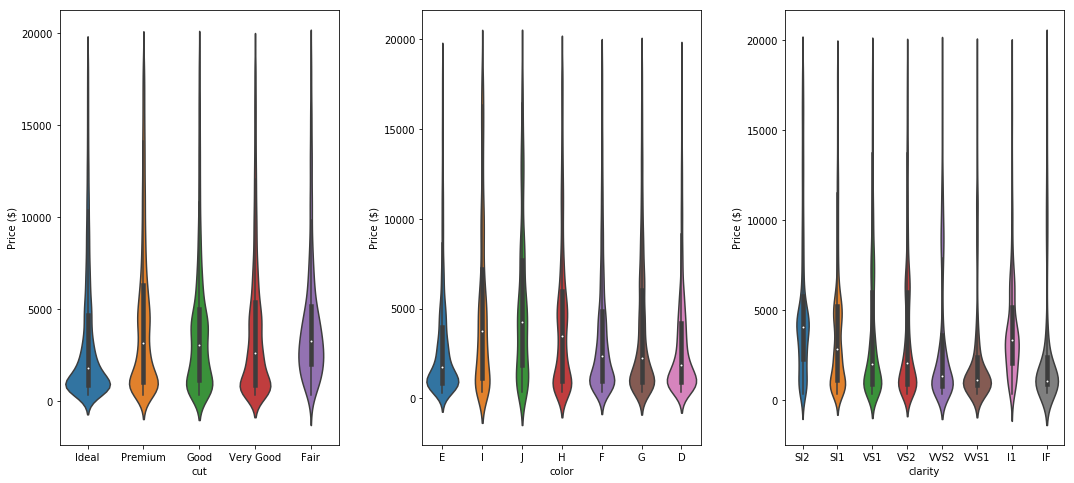

In [27]:
fig, ax = plt.subplots(figsize = (18,8), ncols = 3)

sns.violinplot(x = "cut", y = "price",data = data, ax = ax[0])
ax[0].set_ylabel("Price ($)")

sns.violinplot(x = "color", y = "price", data = data, ax = ax[1])
ax[1].set_ylabel("Price ($)")

sns.violinplot(x = "clarity", y = "price", data = data, ax = ax[2])
ax[2].set_ylabel("Price ($)")

fig.subplots_adjust(wspace=0.3)

plt.show()

Now we shall look at the relationship between each continuous variable individually with the price. The 6 plots are illustrated below.

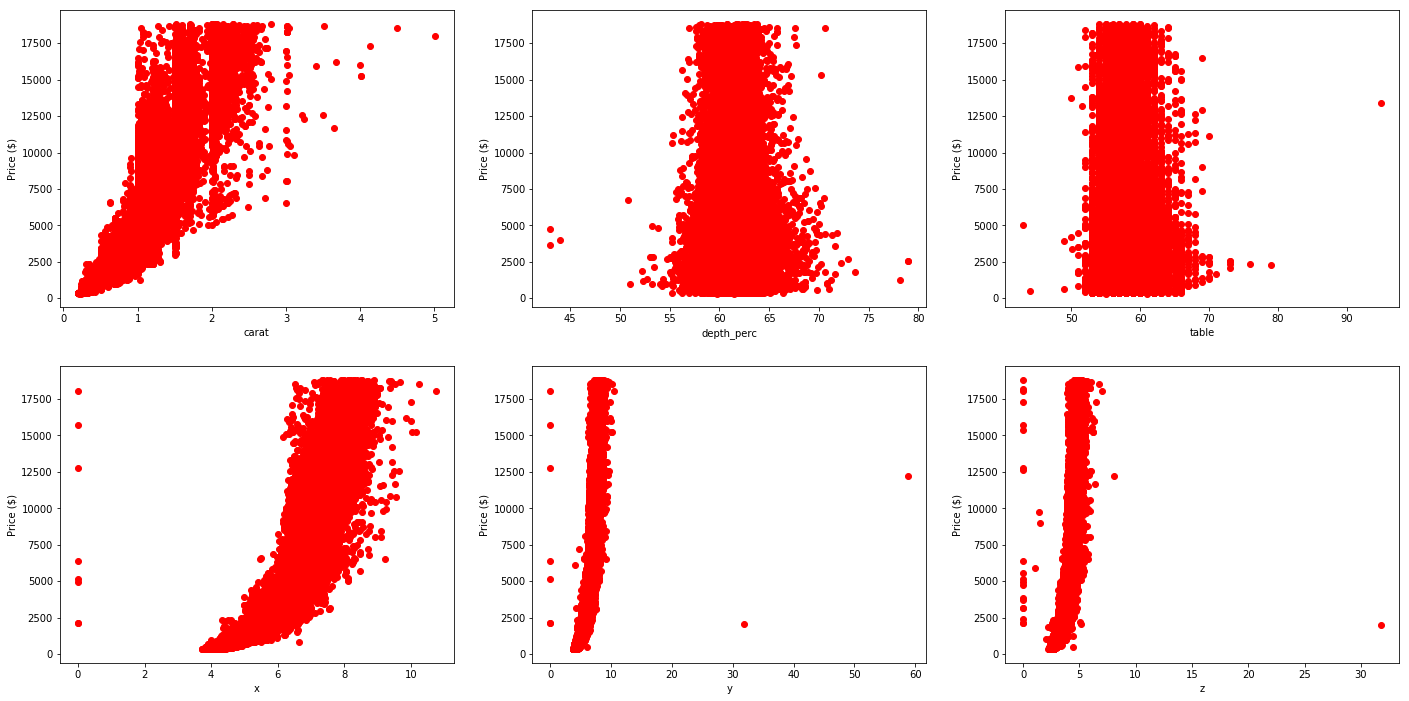

In [28]:
fig, ax = plt.subplots(figsize=(24,12),ncols = 3, nrows = 2)

ax[0][0].scatter(data["carat"],data["price"], color = "red")
ax[0][0].set_xlabel("carat")
ax[0][0].set_ylabel("Price ($)")

ax[0][1].scatter(data["depth_perc"],data["price"], color = "red")
ax[0][1].set_xlabel("depth_perc")
ax[0][1].set_ylabel("Price ($)")

ax[0][2].scatter(data["table"],data["price"], color = "red")
ax[0][2].set_xlabel("table")
ax[0][2].set_ylabel("Price ($)")

ax[1][0].scatter(data["x"],data["price"], color = "red")
ax[1][0].set_xlabel("x")
ax[1][0].set_ylabel("Price ($)")

ax[1][1].scatter(data["y"],data["price"], color = "red")
ax[1][1].set_xlabel("y")
ax[1][1].set_ylabel("Price ($)")

ax[1][2].scatter(data["z"],data["price"], color = "red")
ax[1][2].set_xlabel("z")
ax[1][2].set_ylabel("Price ($)")

plt.show()

From the scatter plots above, it seems that depth_perc and table don't have much effect on price. The other continous variables seem to have an exponential relationship with price.

Next, we will plot a heatmap which illustrates the correlation between each pair of variables. This will give us a clearer idea of the relationship between the different variables. However, before we do this, we need to convert each of the labels of the categoric variables from strings to integers. As each categoric variable is ordinal (ie, there is a clear ranking of each label within a category), we will use label encoding. This is where each label gets converted to a number where the smaller the number, the 'worse' the label is considered to be. So for example, the "cut" variable has 5 different labels and each label will be converted to a different integer between 0 and 4 (inclusive), where 0 is considered to be the "worst" cut label and 4 is considered to the "best" cut label.


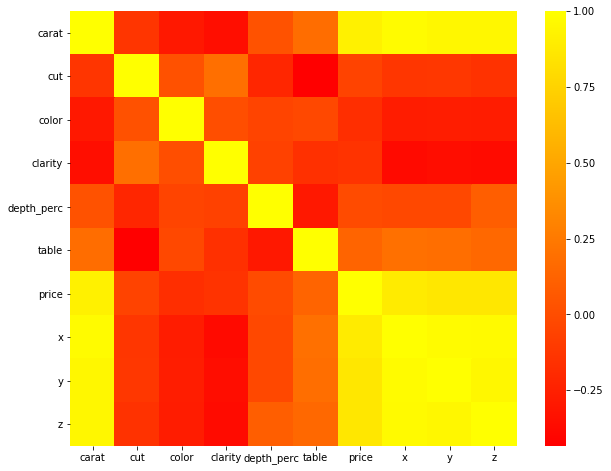

In [29]:
fig, ax = plt.subplots(figsize = (10,8))
data2 = data[:]
data2["cut"] = data2["cut"].replace({ "Fair":0, "Good":1, "Very Good":2, "Premium":3, "Ideal":4})
data2["color"] = data2["color"].replace({"J":0,"I":1,"H":2,"G":3,"F":4,"E":5,"D":4})
data2["clarity"] = data2["clarity"].replace({"I1":0, "SI2":1, "SI1":2, "VS2":3, "VS1":4, "VVS2":5, "VVS1":6, "IF":7})
sns.heatmap(data2.corr(),cmap="autumn", ax = ax)
plt.show()

Once again we can observe that depth_perc and table have very little correlation with price, and the other variables have quite a strong correlation with price. Furthermore, we can also see that carat is very closely related to x, y and z. Also, it is clear that carat, x, y and z seem to also have a strong correlation with price. So this may suggest that the size of a diamond and its carat (ie, weight) probably influence its price the most. Intuitively, this is probably what you would expect.


# Classification

Next, we shall apply a few machine learning techniques with the aim of predicting a diamond's price, given information about all the other variables. We will apply 5 classification methods and then compare the performance of these by looking at their respective ROC and PR curves. At the moment, the price variable is made up of continous data so in order for us to be able to use the classifation methods, we need to change this continous data into labels. 

For the purpose of this report, we shall just split the price data into 2 labels- "low" and "high". To determine the point at which the price data will be split, we calculate the median price; as you can see below, the median is 2401. Splitting the data at the median enables us to divide all the data points equally between the 2 labels which will give us a more reliable classification analysis.

In [15]:
np.median(data2.price)

2401.0

We will test 5 different classification methods on the data: Logistic Regression, k-Nearest Neighbors (k set as 3), Linear Support Vector Classification, Random Forests and AdaBoost.

The data is randomly split into 2 equally sized datasets - one will correspond to the testing data and the other will corresponds to the training data.

In [16]:
classifier_names = ["Logistic Regression",
                    "Nearest Neighbors",
                    "Linear SVM", 
                    "Random Forest",
                    "AdaBoost"]

classifiers = [LogisticRegression(C=1., solver='lbfgs'),
               KNeighborsClassifier(3),
               SVC(kernel="linear", C=0.025, probability=True),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
               AdaBoostClassifier()]

pred_prob = {}
pred = {}


Y = data2["price"] >= np.median(data2.price)
X = data2.drop(["price"], axis = 1)
Y.value_counts()

np.random.seed(100)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5, random_state=0)

for name, classifier in zip(classifier_names, classifiers):
    np.random.seed(100)
    classifier.fit(X_train,Y_train)
    pred_prob[name] = classifier.predict_proba(X_test)[:,1]
    pred[name] = np.where(pred_prob[name] >= 0.5, 1, 0)



The code below corresponds to the 2 functions that we will use to plot the ROC and PR curves for each classifier. This will enable us to measure each classifier's performance.

In [17]:

def get_iterable(x):
    if isinstance(x, list):
        return x
    else:
        return [x]

def plot_roc(Y_test, pred_prob, names, plot_size):
    plt.clf()
    fig = plt.figure(figsize=(plot_size,plot_size))
    ax = fig.add_subplot(1, 1, 1)
    
    names = get_iterable(names)
    for name in names:
        fpr, tpr, _ = roc_curve(Y_test, pred_prob[name])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=1, label= name + ' (area = %0.3f)' % roc_auc)
        
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=9)
    plt.show()
    
    
def plot_pr(Y_test, pred_prob, names, plot_size):
    plt.clf()
    fig = plt.figure(figsize=(plot_size,plot_size))
    ax = fig.add_subplot(1, 1, 1)
    
    names = get_iterable(names)
    for name in names:
        precision, recall, _ = precision_recall_curve(Y_test,pred_prob[name])
        avg_precision = average_precision_score(Y_test, pred_prob[name])
        ax.plot(recall, precision, lw=1, label=name + ' (area = %0.3f)' % avg_precision);
         
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.01])
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=9)
    plt.show()

First, we shall plot the ROC curves. Ideally we would like the ROC curves to be as close as possible to the top left (ie, minimise the false positive rate and maximise the true positive rate). The closeness of a curve to the top left can be characterised by the area under the curve. As we can see in the plot below, the ROC curves for each classifier are very similar; there is very little to choose between them. If we were to be precise, the AdaBoost classifer performs the best as the area under the curve is the highest at 0.998. The worst performing classifer (according to the ROC curves) is the Nearest Neighbours classifier (with k set as 3), with the area under the curve being 0.984.

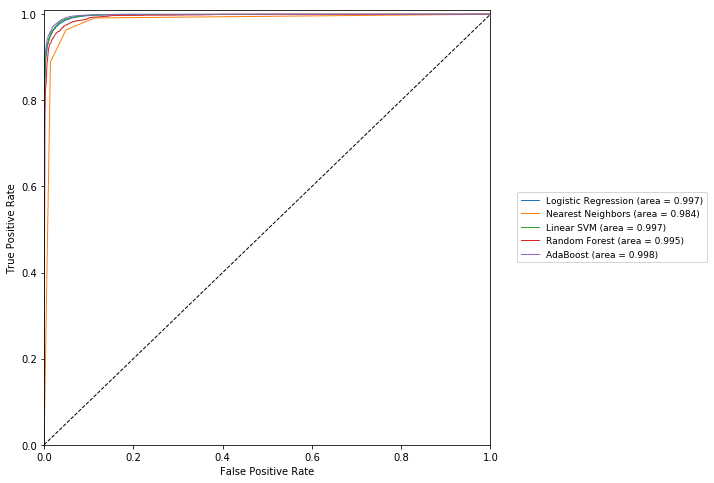

In [18]:
plot_roc(Y_test, pred_prob, classifier_names,8)

Now we shall plot the PR curves for each classifier. It is important to look at both the ROC and PR curves as quite often they can give contradicting results. In contrast to the ROC curves, we would like the PR curves to be as close as possible to the top right of the graph; this helps to maximise the precision and recall. Once again, we can observe that each classifier has a very similar, impressive performance. AdaBoost has the largest area under its curve (0.998) and Nearest Neighbours performs the worst again (area = 0.975).

So by looking at both the ROC and PR curves, we can conclude that AdaBoost seems to perform the best (although, as mentioned, there is very little to choose between the classifiers).

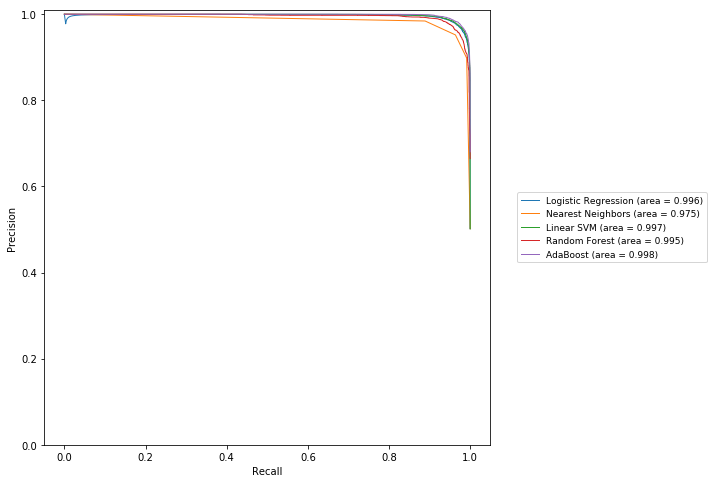

In [19]:
plot_pr(Y_test, pred_prob, classifier_names,8)

# Conclusion

#### Key Findings


From our analysis, we found a number of key observations.

* The price of diamonds seems to follow an exponential distribution with very long upper tails. 

* The main attributes affecting the price of a diamond are its dimensions (ie, length, width and depth) and its carat (ie, weight). 

* We were surprised to find that cut, color and clarity didn't affect the price of a diamond in the way we'd expect. Perhaps a combination of these variables plays a bigger part in affecting a diamond's price.

* When the price data was split into 2 labels ("High" and "Low"), the 5 classification models we tested all performed very well. AdaBoost was very narrowly the best out of the 5. 

#### Next Steps

* It may be worth performing some classification analysis when the price data is divided into more than 2 labels and see if the models still perform as well or not. 

* Could also look at regression models as these would probably be more useful in the real world. 
